# 1.Loading the files  

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

# List of file paths for the Excel files
file_paths = ["Youtube01-Psy.csv", "Youtube02-KatyPerry.csv", "Youtube03-LMFAO.csv", "Youtube04-Eminem.csv", "Youtube05-Shakira.csv"]

# Create an empty list to store the DataFrames
dfs = []

# Iterate over the file paths and read each Excel file into a DataFrame
for file_path in file_paths:
    df = pd.read_csv(file_path)
    dfs.append(df)

# Concatenate the DataFrames into a single DataFrame
combined_df = pd.concat(dfs)
combined_df = combined_df.reset_index()
combined_df= combined_df.drop(["index"], axis =1)
print()
# Print the combined DataFrame
output_file = "combined_file.xlsx"
combined_df.to_excel(output_file, index= False)

print("Combined DataFrame saved as", output_file)


Combined DataFrame saved as combined_file.xlsx


In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

In [4]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [5]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# 2. EDA

## Text Analysis & Preproccessing


In [6]:
def preprocess_text(text):

    #Replace url with the world "url"
    url= r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(url,'web',text)

    # Replace email addresses with the word "email"
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b'
    text = re.sub(email_pattern, 'email', text)

    #Replace numbers to "num"
    number = r'\d+(\.\d+)?'
    text = re.sub(number,'num',text)

    #Remove special characters
    character = r'[^\w\s]'
    text = re.sub(character,'',text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.lower() not in stop_words]

    # Perform lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join the tokens back into a single string
    tokens = ' '.join(tokens)

    # Return the preprocessed text as a string
    return tokens

In [8]:
combined_df['preprocessed_text_r_l'] = combined_df['CONTENT'].apply(preprocess_text)
print(combined_df['preprocessed_text_r_l'].head(10))

0         Huh anyway check youtube channel kobyoshinum
1    Hey guy check new channel first vid US MONKEYS...
2                                   test say murdevcom
3                        shaking sexy as channel enjoy
4                              watchvvtaRGgvGtWQ Check
5    Hey check new website site kid stuff kidsmedia...
6                                    Subscribe channel
7              turned mute soon came wanted check view
8                           check channel Funny VIDEOS
9                    u shouldd check channel tell next
Name: preprocessed_text_r_l, dtype: object


## Feature Extraction from Text

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

shuffled_df = shuffle(combined_df)

X = shuffled_df['preprocessed_text_r_l']
y = shuffled_df['CLASS']

class_counts = y.value_counts()
print("Class Counts:")
print(class_counts)

Class Counts:
CLASS
1    1005
0     951
Name: count, dtype: int64


Class Counts:
CLASS
1    1005
0     951
Name: count, dtype: int64


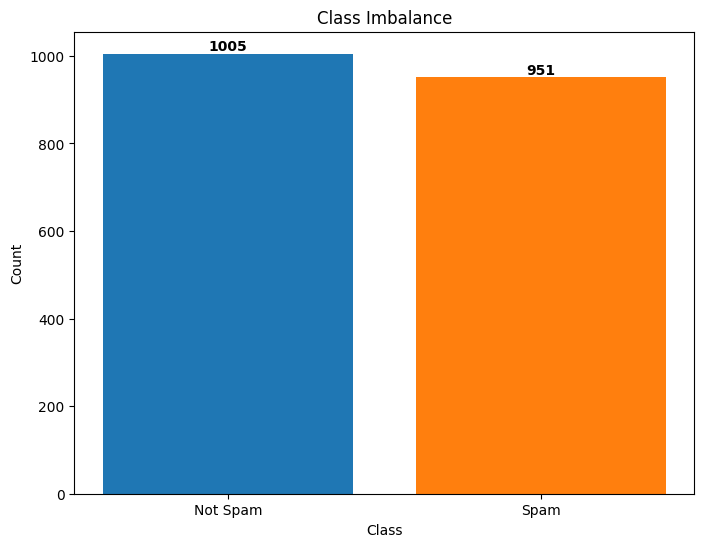

In [10]:
import matplotlib.pyplot as plt

class_counts = y.value_counts()
print("Class Counts:")
print(class_counts)


class_labels = ['Not Spam', 'Spam']
class_values = class_counts.values


colors = ['#1f77b4', '#ff7f0e']

plt.figure(figsize=(8, 6))
plt.bar(class_labels, class_values, color=colors)


for i, v in enumerate(class_values):
    plt.text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Imbalance")
plt.show()

In [11]:
#tfidf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(combined_df['preprocessed_text_r_l'])
y = combined_df['CLASS']

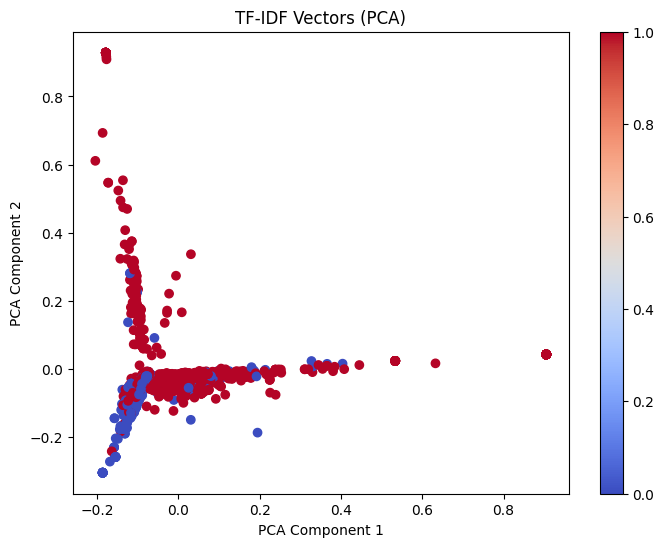

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform dimensionality reduction using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Create a scatter plot of the TF-IDF vectors
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("TF-IDF Vectors (PCA)")
plt.colorbar()
plt.show()

In [13]:
!pip install wordcloud

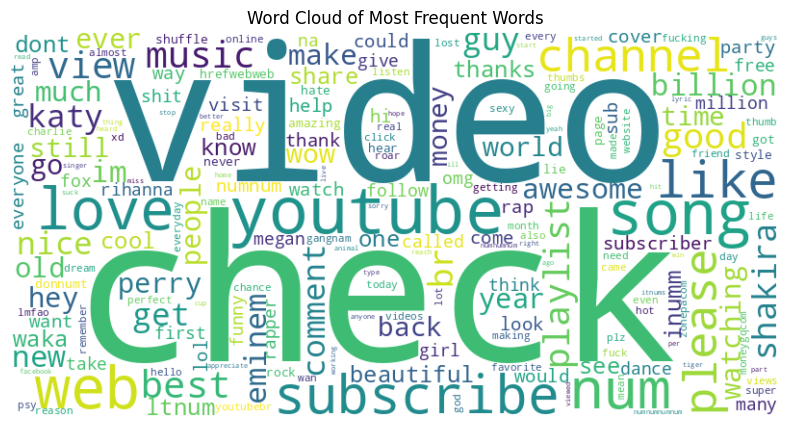

In [14]:
from wordcloud import WordCloud

words = vectorizer.get_feature_names_out()

word_frequencies = dict(zip(words, X.toarray().sum(axis=0)))

wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_frequencies)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Most Frequent Words")
plt.show()

# 4. Training & Modelling

In [15]:
#spliting training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Accuracy

In [16]:
#Logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
model_lr = LogisticRegression(random_state = 42)
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("LogisticRegression Testing Accuracy:", accuracy_lr)

#Support Vector Machines
from sklearn.svm import SVC
model_svc = SVC(random_state = 42)
model_svc.fit(X_train, y_train)
y_pred_svm = model_svc.predict(X_test)
accuracy_svc = accuracy_score(y_test, y_pred_svm)
print("SVC Testing Accuracy:", accuracy_svc)

#Random Forest
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(random_state = 42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("RandomForest Testing Accuracy:", accuracy_rf)

#Knn
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)
y_pred_knn = model_knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("KNN Testing Accuracy:", accuracy_knn)


LogisticRegression Testing Accuracy: 0.9311224489795918
SVC Testing Accuracy: 0.9311224489795918
RandomForest Testing Accuracy: 0.9413265306122449
KNN Testing Accuracy: 0.6326530612244898


### **Fine tuning**


In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression

#Logistic regression
lr_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'penalty': ['l2'],'solver': ['liblinear']}
lr_grid_search = (GridSearchCV(LogisticRegression(),
                               lr_param_grid,
                               cv=stratified_kfold,
                               scoring='accuracy'))

lr_grid_search.fit(X_train, y_train)
print("Best parameters for Logistic Regression:", lr_grid_search.best_params_)
print("Best scoring:", lr_grid_search.best_score_)
y_pred_lr = lr_grid_search.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("LogisticRegression Testing Accuracy:", accuracy_lr)

Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best scoring: 0.9194294257393298
LogisticRegression Testing Accuracy: 0.9362244897959183


In [ ]:
from sklearn.svm import SVC

#svm
svc_param_grid = {'C': [10**x for x in range(-5, 3)], 'kernel': ['linear', 'rbf']}
svc_grid_search = GridSearchCV(SVC(), svc_param_grid, cv=stratified_kfold, scoring='accuracy')
svc_grid_search.fit(X_train, y_train)
print("Best parameters for SVC:", svc_grid_search.best_params_)
print("Best scoring:", svc_grid_search.best_score_)
y_pred_svm = svc_grid_search.predict(X_test)
accuracy_svc = accuracy_score(y_test, y_pred_svm)
print("SVC Testing Accuracy:", accuracy_svc)

Best parameters for SVC: {'C': 1, 'kernel': 'linear'}
Best scoring: 0.9258232981076432
SVC Testing Accuracy: 0.9413265306122449


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_param_grid = {'n_estimators': [10, 50, 100, 200, 300], 'max_depth': [None, 10, 20, 30, 40]}

rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=stratified_kfold, scoring='accuracy')

rf_grid_search.fit(X_train, y_train)

print("Best parameters for Random Forest:", rf_grid_search.best_params_)
print("Best scoring:", rf_grid_search.best_score_)

y_pred_rf = rf_grid_search.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("RandomForest Testing Accuracy:", accuracy_rf)
# default better in test set, this kind of overfitting
# n_estimatorsint, default=100
# max_depthint, default=None


Best parameters for Random Forest: {'max_depth': None, 'n_estimators': 100}
Best scoring: 0.9430920783157205
RandomForest Testing Accuracy: 0.9413265306122449


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

#knn
knn_param_grid = ({'n_neighbors': [i for i in range(3,40) ],
                   'weights': ['uniform', 'distance']})
knn_grid_search = (GridSearchCV(KNeighborsClassifier(),
                                knn_param_grid,
                                cv=stratified_kfold,
                                scoring='accuracy'))
knn_grid_search.fit(X_train, y_train)
print("Best parameters for KNN:", knn_grid_search.best_params_)
print("Best scoring:", knn_grid_search.best_score_)
y_pred_knn = knn_grid_search.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("KNN Testing Accuracy:", accuracy_knn)


Best parameters for KNN: {'n_neighbors': 26, 'weights': 'distance'}
Best scoring: 0.8529470795445236
KNN Testing Accuracy: 0.8137755102040817


## Precision, Recall, F1-score

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Logistic Regression
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

print("Logistic Regression Precision:", precision_lr)
print("Logistic Regression Recall:", recall_lr)
print("Logistic Regression F1-score:", f1_lr)

# Support Vector Machines
precision_svc = precision_score(y_test, y_pred_svm, average='weighted')
recall_svc = recall_score(y_test, y_pred_svm, average='weighted')
f1_svc = f1_score(y_test, y_pred_svm, average='weighted')

print("Support Vector Machines Precision:", precision_svc)
print("Support Vector Machines Recall:", recall_svc)
print("Support Vector Machines F1-score:", f1_svc)

# Random Forest
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print("Random Forest Precision:", precision_rf)
print("Random Forest Recall:", recall_rf)
print("Random Forest F1-score:", f1_rf)

# KNN
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

print("KNN Precision:", precision_knn)
print("KNN Recall:", recall_knn)
print("KNN F1-score:", f1_knn)

Logistic Regression Precision: 0.9400715111987982
Logistic Regression Recall: 0.9362244897959183
Logistic Regression F1-score: 0.936387327974583
Support Vector Machines Precision: 0.9430562468889995
Support Vector Machines Recall: 0.9413265306122449
Support Vector Machines F1-score: 0.9414490045640368
Random Forest Precision: 0.9414629218023843
Random Forest Recall: 0.9387755102040817
Random Forest F1-score: 0.9389211798924606
KNN Precision: 0.8470238852687402
KNN Recall: 0.8137755102040817
KNN F1-score: 0.8125989721071804


In [ ]:
from sklearn.metrics import confusion_matrix

cm_lr = confusion_matrix(y_test, y_pred_lr)
print("LogisticRegression Confusion Matrix:")
print(cm_lr)

cm_svc = confusion_matrix(y_test, y_pred_svm)
print("SVC Confusion Matrix:")
print(cm_svc)

cm_rf = confusion_matrix(y_test, y_pred_rf)
print("RandomForest Confusion Matrix:")
print(cm_rf)

cm_knn = confusion_matrix(y_test, y_pred_knn)
print("KNN Confusion Matrix:")
print(cm_knn)

LogisticRegression Confusion Matrix:
[[172   4]
 [ 21 195]]
SVC Confusion Matrix:
[[170   6]
 [ 17 199]]
RandomForest Confusion Matrix:
[[171   5]
 [ 19 197]]
KNN Confusion Matrix:
[[168   8]
 [ 65 151]]


# Visualise Model

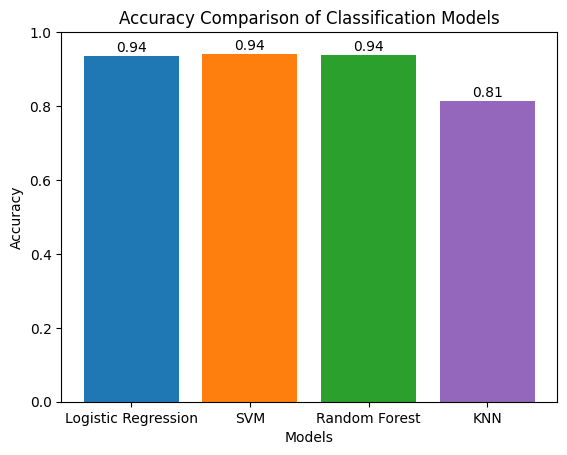

In [ ]:
# Accuracy values
accuracies = [accuracy_lr, accuracy_svc, accuracy_rf, accuracy_knn]

# Model names
model_names = ['Logistic Regression', 'SVM', 'Random Forest', 'KNN']

# Color for each bar
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd']

# Create bar plot
plt.bar(model_names, accuracies, color=colors)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Classification Models')
plt.ylim([0.0, 1.0])  # Set the y-axis limits between 0 and 1

# Add numbers on top of each bar
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, str(round(v, 2)), ha='center')

# Save the plot as a file
plt.savefig('accuracy_plot.png')

# Show the plot
plt.show()

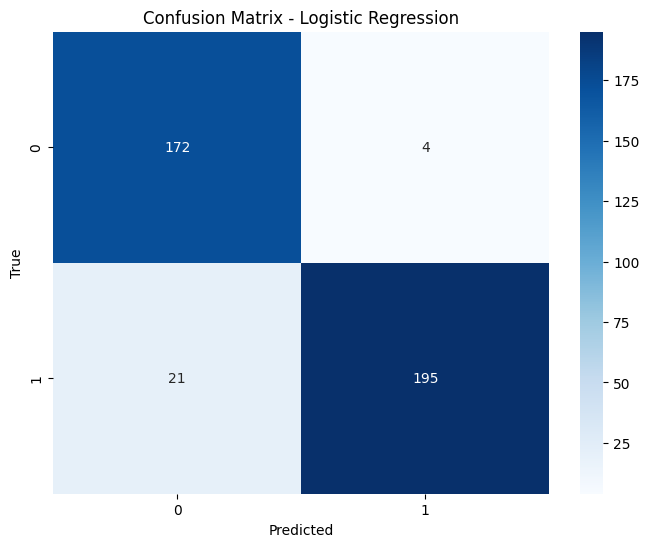

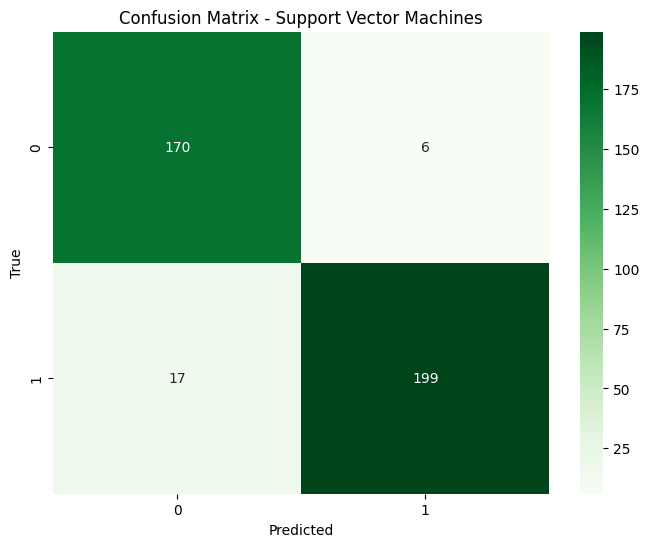

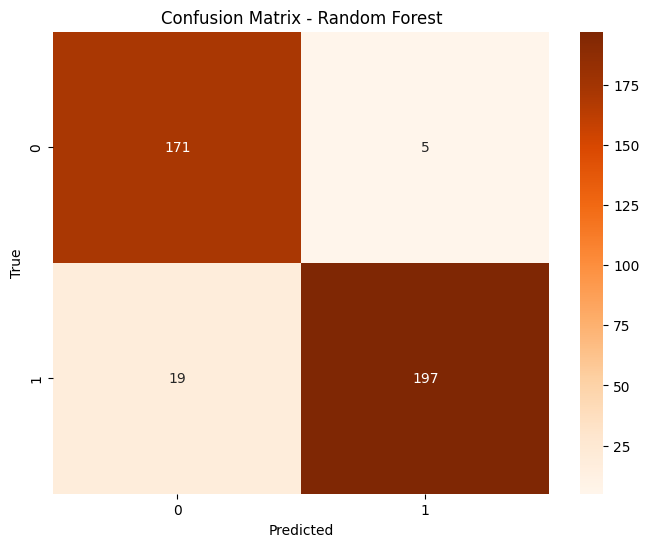

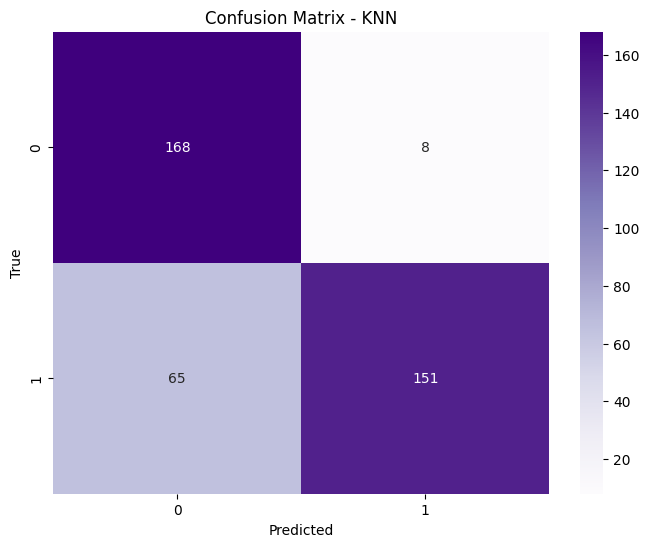

In [ ]:
# Confusion matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)

# Confusion matrix for Support Vector Machines
cm_svc = confusion_matrix(y_test, y_pred_svm)

# Confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Confusion matrix for KNN
cm_knn = confusion_matrix(y_test, y_pred_knn)

# Function to plot confusion matrix with different colormap
def plot_confusion_matrix(cm, title, cmap):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)

# Plot confusion matrix for Logistic Regression with "Blues" colormap
plot_confusion_matrix(cm_lr, 'Confusion Matrix - Logistic Regression', cmap='Blues')
plt.show()

# Plot confusion matrix for Support Vector Machines with "Greens" colormap
plot_confusion_matrix(cm_svc, 'Confusion Matrix - Support Vector Machines', cmap='Greens')
plt.savefig('cm_svm.png')
plt.show()

# Plot confusion matrix for Random Forest with "Oranges" colormap
plot_confusion_matrix(cm_rf, 'Confusion Matrix - Random Forest', cmap='Oranges')
plt.savefig('cm_rf.png')
plt.show()

# Plot confusion matrix for KNN with "Purples" colormap
plot_confusion_matrix(cm_knn, 'Confusion Matrix - KNN', cmap='Purples')
plt.savefig('cm_knn.png')
plt.show()

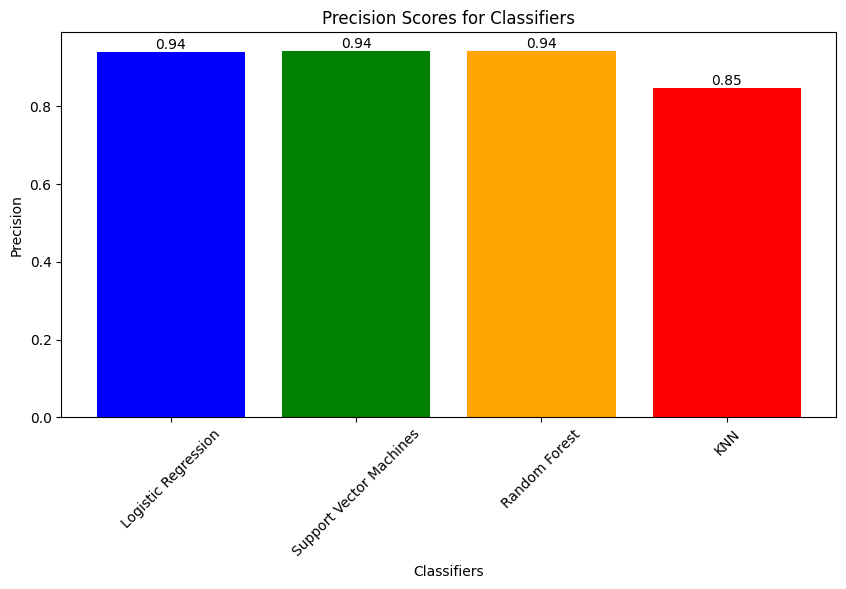

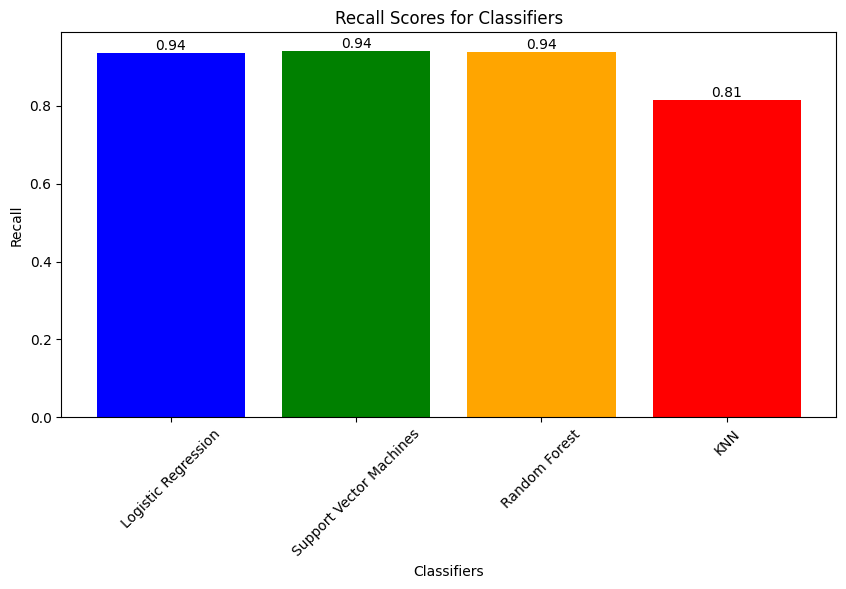

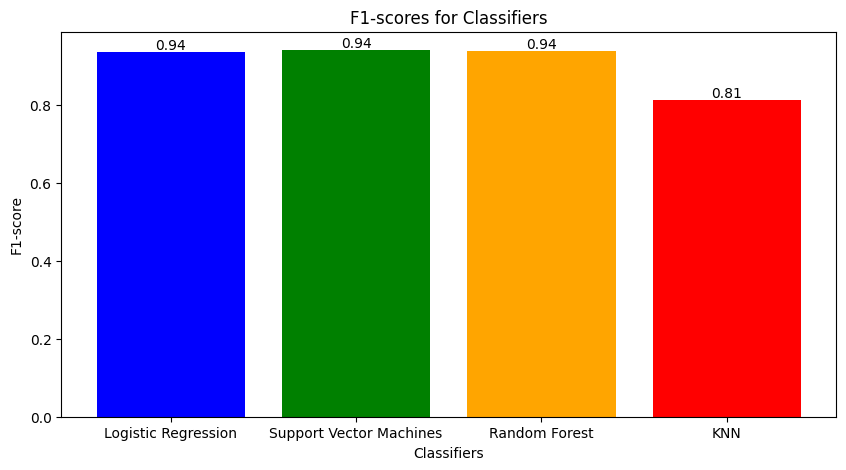

In [ ]:
import matplotlib.pyplot as plt

# Create a list of classifier names
classifiers = ['Logistic Regression', 'Support Vector Machines', 'Random Forest', 'KNN']

# Create a list of precision scores
precision_scores = [precision_lr, precision_svc, precision_rf, precision_knn]

# Create a list of recall scores
recall_scores = [recall_lr, recall_svc, recall_rf, recall_knn]

# Create a list of F1-scores
f1_scores = [f1_lr, f1_svc, f1_rf, f1_knn]

# Define colors for each model
colors = ['blue', 'green', 'orange', 'red']

# Plot precision scores
plt.figure(figsize=(10, 5))
plt.bar(classifiers, precision_scores, color=colors)
plt.xlabel('Classifiers')
plt.ylabel('Precision')
plt.title('Precision Scores for Classifiers')
plt.xticks(rotation=45)

# Label each bar with its value
for i, score in enumerate(precision_scores):
    plt.text(i, score, f"{score:.2f}", ha='center', va='bottom')

plt.show()

# Plot recall scores
plt.figure(figsize=(10, 5))
plt.bar(classifiers, recall_scores, color=colors)
plt.xlabel('Classifiers')
plt.ylabel('Recall')
plt.title('Recall Scores for Classifiers')
plt.xticks(rotation=45)

# Label each bar with its value
for i, score in enumerate(recall_scores):
    plt.text(i, score, f"{score:.2f}", ha='center', va='bottom')

plt.show()

# Plot F1-scores
plt.figure(figsize=(10, 5))
plt.bar(classifiers, f1_scores, color=colors)
plt.xlabel('Classifiers')
plt.ylabel('F1-score')
plt.title('F1-scores for Classifiers')

# Label each bar with its value
for i, score in enumerate(f1_scores):
    plt.text(i, score, f"{score:.2f}", ha='center', va='bottom')

plt.savefig('F1.png')
plt.show()

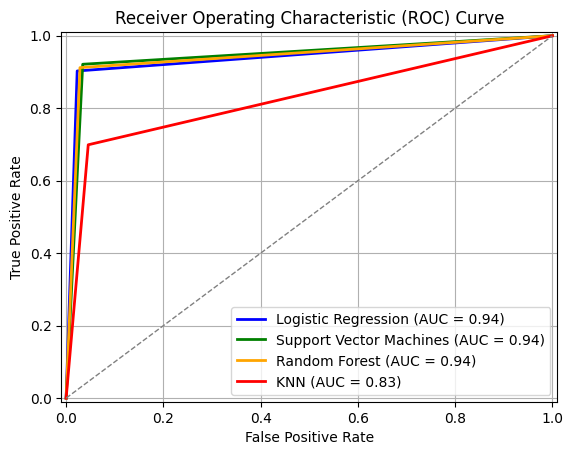

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC for Logistic Regression
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Compute ROC curve and AUC for Support Vector Machines
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, y_pred_svm)
roc_auc_svc = auc(fpr_svc, tpr_svc)

# Compute ROC curve and AUC for Random Forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Compute ROC curve and AUC for KNN
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_pred_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Plot ROC curve for Logistic Regression
plt.figure()
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label='Logistic Regression (AUC = %0.2f)' % roc_auc_lr)

# Plot ROC curve for Support Vector Machines
plt.plot(fpr_svc, tpr_svc, color='green', lw=2, label='Support Vector Machines (AUC = %0.2f)' % roc_auc_svc)

# Plot ROC curve for Random Forest
plt.plot(fpr_rf, tpr_rf, color='orange', lw=2, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)

# Plot ROC curve for KNN
plt.plot(fpr_knn, tpr_knn, color='red', lw=2, label='KNN (AUC = %0.2f)' % roc_auc_knn)

# Set plot properties
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)

# Show the plot
plt.savefig('roc.png')
plt.show()

### **NN Fine Tuning(searching the best parameters )**

In [17]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 3.8 MB/s eta 0:00:00


In [34]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# Define your neural network class as before
class SpamDetector(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SpamDetector, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

def objective(trial, X_train, y_train, X_test, y_test):
    # Assuming X_train and X_test are sparse matrices, convert them to dense arrays
    X_train_dense = X_train.toarray() if hasattr(X_train, "toarray") else X_train
    X_test_dense = X_test.toarray() if hasattr(X_test, "toarray") else X_test

    # Then convert your datasets to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_dense, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Ensuring the correct shape
    X_test_tensor = torch.tensor(X_test_dense, dtype=torch.float32)

    input_size = X_train_tensor.shape[1]
    output_size = 1
    hidden_size = trial.suggest_int('hidden_size',16, 128)
    learning_rate = trial.suggest_loguniform('learning_rate',1e-4, 1e-1)

    model_nn = SpamDetector(input_size, hidden_size, output_size)
    optimizer = optim.Adam(model_nn.parameters(), lr=learning_rate)
    loss_fn = nn.BCELoss()
    #train_losses = []
    num_epochs = 10
    for epoch in range(num_epochs):
        model_nn.train()
        optimizer.zero_grad()
        predictions = model_nn(X_train_tensor)
        loss = loss_fn(predictions, y_train_tensor)
        loss.backward()
        optimizer.step()
        #train_losses.append(loss.item())
    model_nn.eval()
    with torch.no_grad():
        y_pred_nn = model_nn(X_test_tensor)
        y_pred_nn = torch.round(y_pred_nn).numpy().astype(int)

    accuracy = accuracy_score(y_test, y_pred_nn)

    return accuracy

# Assuming you have your datasets loaded in X_train, y_train, X_test, y_test
# Main hyperparameter tuning with Optuna
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=100)

# Print the optimal hyperparameters
print("################################\n")
best_trial = study.best_trial
print(f"Best trial final loss: {best_trial.value}")
print(f"Best trial params: {best_trial.params}")

[I 2024-04-23 09:29:10,879] A new study created in memory with name: no-name-56bc03c8-8088-4b88-8a87-2ff018e8cfb3
<ipython-input-34-deb753da8a96>:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate',1e-4, 1e-1)
[I 2024-04-23 09:29:12,202] Trial 0 finished with value: 0.8877551020408163 and parameters: {'hidden_size': 94, 'learning_rate': 0.0012756003352556516}. Best is trial 0 with value: 0.8877551020408163.
<ipython-input-34-deb753da8a96>:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate',1e-4, 1e-1)
[I 2024-04-23 09:29:13,787] Trial 1 finished with value: 0.89

################################

Best trial final loss: 0.923469387755102
Best trial params: {'hidden_size': 76, 'learning_rate': 0.02761255046744856}


### **Optimized**

Accuracy: 0.9183673469387755


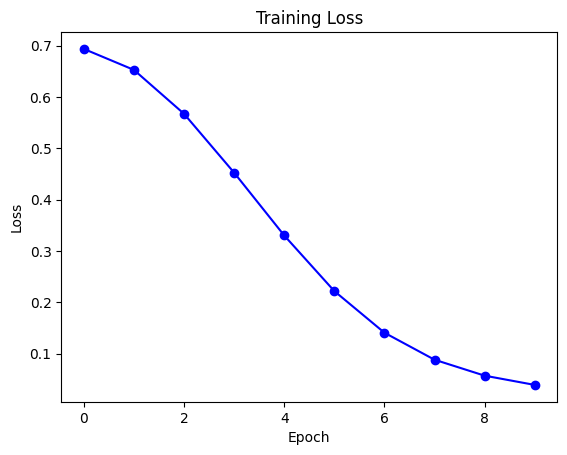

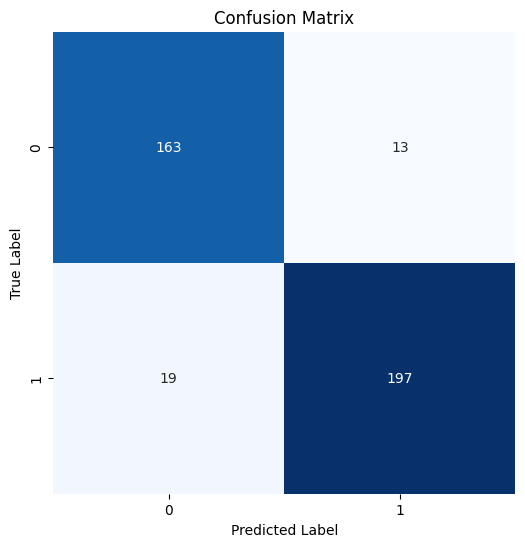

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       176
           1       0.94      0.91      0.92       216

    accuracy                           0.92       392
   macro avg       0.92      0.92      0.92       392
weighted avg       0.92      0.92      0.92       392



In [38]:
def train_and_evaluate(X_train_tensor, y_train_tensor, X_test_tensor, y_test, params):
    input_size = X_train_tensor.shape[1]
    output_size = 1
    hidden_size = params['hidden_size']
    learning_rate = params['learning_rate']

    X_train_dense = X_train.toarray() if hasattr(X_train, "toarray") else X_train
    X_test_dense = X_test.toarray() if hasattr(X_test, "toarray") else X_test

    # Then convert your datasets to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_dense, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Ensuring the correct shape
    X_test_tensor = torch.tensor(X_test_dense, dtype=torch.float32)

    model_nn = SpamDetector(input_size, hidden_size, output_size)
    optimizer = optim.Adam(model_nn.parameters(), lr=learning_rate)
    loss_fn = nn.BCELoss()

    num_epochs = 10
    train_losses = []
    for epoch in range(num_epochs):
        model_nn.train()
        optimizer.zero_grad()
        predictions = model_nn(X_train_tensor)
        loss = loss_fn(predictions, y_train_tensor)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    # Evaluate the model
    model_nn.eval()
    with torch.no_grad():
        y_pred_nn = model_nn(X_test_tensor)
        y_pred_nn = torch.round(y_pred_nn).numpy().astype(int)

    accuracy = accuracy_score(y_test, y_pred_nn)
    print(f"Accuracy: {accuracy}")

    # Plot training loss
    plt.plot(train_losses, 'b-o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.savefig('epoch.png')
    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred_nn)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', square=True, cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    print(classification_report(y_test, y_pred_nn))

# Assuming your datasets (X_train_tensor, y_train_tensor, X_test_tensor, y_test) are already defined and properly formatted
best_trial_params = {'hidden_size': 76, 'learning_rate': 0.02761255046744856}
train_and_evaluate(X_train, y_train, X_test, y_test, best_trial_params)

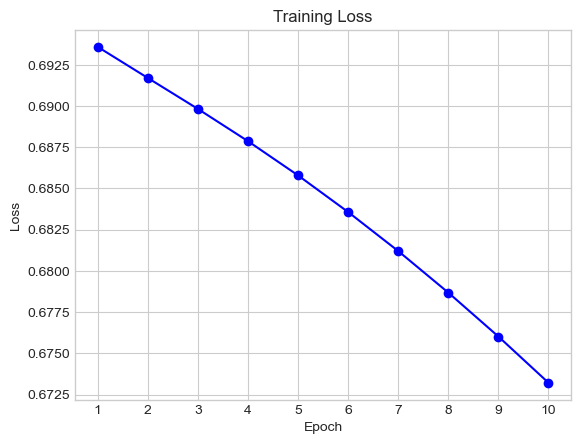

In [ ]:
loss_values = [0.6935849189758301, 0.6916998028755188, 0.6898218393325806, 0.6878666877746582, 0.6857904195785522,
               0.6835685968399048, 0.681202232837677, 0.6786813735961914, 0.6760186553001404, 0.6732141971588135]

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'b-o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.xticks(epochs)
plt.savefig('epoch.png')
plt.show()

# Original Text Modelling

In [ ]:
X_o = vectorizer.fit_transform(combined_df['CONTENT'])
y_o = combined_df['CLASS']
X_o_train, X_o_test, y_o_train, y_o_test = train_test_split(X_o, y_o, test_size=0.2, random_state=42)

In [ ]:
#Logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
model_lr = LogisticRegression()
model_lr.fit(X_o_train, y_o_train)
y_o_pred_lr = model_lr.predict(X_o_test)
accuracy_o_lr = accuracy_score(y_o_test, y_o_pred_lr)
print("LogisticRegression Testing Accuracy:", accuracy_o_lr)

#Support Vector Machines
from sklearn.svm import SVC
model_svc = SVC()
model_svc.fit(X_o_train, y_o_train)
y_o_pred_svm = model_svc.predict(X_o_test)
accuracy_o_svc = accuracy_score(y_o_test, y_o_pred_svm)
print("SVC Testing Accuracy:", accuracy_o_svc)

#Random Forest
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier()
model_rf.fit(X_o_train, y_o_train)
y_o_pred_rf = model_rf.predict(X_o_test)
accuracy_o_rf = accuracy_score(y_o_test, y_o_pred_rf)
print("RandomForest Testing Accuracy:", accuracy_o_rf)

#Knn
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier()
model_knn.fit(X_o_train, y_o_train)
y_o_pred_knn = model_knn.predict(X_o_test)
accuracy_o_knn = accuracy_score(y_o_test, y_o_pred_knn)
print("KNN Testing Accuracy:", accuracy_o_knn)

LogisticRegression Testing Accuracy: 0.9413265306122449
SVC Testing Accuracy: 0.9413265306122449
RandomForest Testing Accuracy: 0.9387755102040817
KNN Testing Accuracy: 0.6096938775510204
